The purpose of this experiment is to use the correlations between the EEG brain recordings of multiple students during a lecture to determine how brain correlation changes with the content of the lecture at a particular time. The premise is that an interesting lecture will lead to students all paying attention to the same stimulus, and thus they will exhibit highly correlated brain activity. Thus, we hope to establish brain correlation as a measure of how interesting a lecture is at each point in time.

First, we import some Python packages.

In [4]:
import os
import pandas as pd
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, stats
%matplotlib inline

We take note of the paths of our raw data of the EEG recordings of each subject during the lecture.

In [5]:
working_dir = os.getcwd()
data_dir = os.path.join(working_dir, "raw_data")

We use pandas to load the csv files into a dataframe, and then export it as a numpy multidimensional array. The shape of each person's recordings, after transposing, is 6 columns x num_timepoints, where the 6 columns are respectively, timestamp, channel 1, channel 2, channel 3, channel 4, and marker. In this experiment, timestamp is the absolute timing of each recording, as measured using Apple's built-in time. We measure absolute time so that even if different devices start to record at different times, we know exactly the offset between the devices, and can align them afterwards to the same starting and ending times. the channels represent the data collected from the 4 electrodes that were located on each subject's forehead and temples. The marker column can be used to add event-related data, however as we do not have discrete classes of events in this experiment, we do not use this column.

The two subjects' data that we use in this example are "pierre" and "gaby".

In [122]:
pierre = pd.read_csv(os.path.join(data_dir, "data_pierre_1.csv")).as_matrix()
pierre_t = pierre[:, 0].astype("int")
gaby = pd.read_csv(os.path.join(data_dir, "data_gaby.csv")).as_matrix()
gaby_t = gaby[:, 0].astype("int")

As mentioned before, due to each device starting and ending recording at different times, as need to align all subjects' data into absolute time. Here, we find that gaby's recording started earlier than pierre and ended later than pierre. Thus, we need to trim gaby's recordings to match pierre's starting and ending timestamps.

In [123]:
print("gaby's start time is", pierre_t[0] - gaby_t[0], "earlier than pierre")
print("gaby's end time is", gaby_t[-1] - pierre_t[-1], "later than pierre")
print("need to trim gaby on both ends to fit pierre")

gaby's start time is 338 earlier than pierre
gaby's end time is 747 later than pierre
need to trim gaby on both ends to fit pierre


In [124]:
gaby = gaby[np.where(gaby_t >= pierre_t[0])]
gaby_t = gaby[:, 0].astype("int")

In [125]:
if pierre_t[0] == gaby_t[0]:
    print("Successfully aligned starting times!")

Successfully aligned starting times!


Now we also trim the gaby's data from the end to match pierre's end time.

In [126]:
"""Trim gaby's end time to match pierre"""
#we find the first index in which gaby's time is larger than pierre's last time
diverging_index = np.where(gaby_t >= pierre_t[-1])[0][0]
#and cut off gaby's timeseries after the diverging_index
gaby = gaby[:diverging_index+1]
gaby_t = gaby[:, 0].astype("int")

In [127]:
print("gaby's start time is", pierre_t[0] - gaby_t[0], "earlier than pierre")
print("gaby's end time is", gaby_t[-1] - pierre_t[-1], "later than pierre")

gaby's start time is 0 earlier than pierre
gaby's end time is 0 later than pierre


In [128]:
if pierre_t[-1] == gaby_t[-1]:
    print("Successfully aligned ending times!")

Successfully aligned ending times!


Now that we've trimmed the two subject's timeseries to the same starting and ending times, there's another issue - different devices might have different sampling rates, which means that we may end up with different samples per the same amount of time between pierre and gaby. This may mess up our correlation calculations later on. Thus, we must find the sampling rates of gaby and pierre, and downsample the one with a higher sampling rate.

In [129]:
gaby_fs = 1/np.mean(np.diff(gaby_t))
print("gaby's sampling frequency is", gaby_fs)
pierre_fs = 1/np.mean(np.diff(pierre_t))
print("pierre's sampling frequency is", pierre_fs)
print("Therefore, pierre has more samples within the same timecourse.")
print("pierre has", len(pierre_t) - len(gaby_t), "more samples than gaby within same timecourse.")
print("Need to downsample pierre to have same number of data points as gaby.")

gaby's sampling frequency is 191.618619413
pierre's sampling frequency is 196.154192013
Therefore, pierre has more samples within the same timecourse.
pierre has 17149 more samples than gaby within same timecourse.
Need to downsample pierre to have same number of data points as gaby.


We use scipy's signal module to resample pierre's data to match gaby's sampling frequency. Now, we have the same number of datapoints within the same amount of time.

In [130]:
"""Resampling pierre to gaby's length"""
pierre = signal.resample(pierre, len(gaby_t))
pierre_t = pierre[:, 0].astype("int")

In [133]:
if len(pierre_t) - len(gaby_t) == 0:
    print("successfully resampled pierre to have the same samples as gaby within the same timecourse.")

successfully resampled pierre to have the same samples as gaby within the same timecourse.


As pierre_fs and gaby_fs are now equal, we collapse the two into a single variable fs (sampling frequency)

In [134]:
fs = gaby_fs

Now that all the data are aligned, we don't need the timestamps column anymore. We only need the data from the four EEG channels.

In [137]:
#only take columns 1-4
pierre_data = pierre[:, 1:5]
gaby_data = gaby[:, 1:5]

In [136]:
pierre_data.shape

(724511, 4)

One last thing before calculating correlations through time: A common issue with electrodes is that there is noise from the equipment itself. Empirical evidence suggests that we should filter our signal to be between 2Hz and 30Hz to best preserve the actual brain signal from the EEG data. Therefore, we design bandpass filter and smooth our data with that filter.

In [138]:
## filter signal to remove noise
b, a = signal.butter(2, (2/(fs/2), 30/(fs/2)), btype='bandpass')
pierre_smoothed = signal.filtfilt(b, a, pierre_data, axis=0)
gaby_smoothed = signal.filtfilt(b, a, gaby_data, axis=0)

We finally calculate the correlations through time of the two timeseries. Because correlation returns a static scalar when applied to two timeseries, we use a sliding window to repeatedly calculate correlations throughout the timeseries. Here the windows variable is the size of the window (how many timepoints to include in a single correlation calculation), and the step variable is how much we should shift the window to the right to calculate the next correlation datapoint.

In [146]:
window = int(fs)
step = int(fs/4)
corr = []
times = []

#advance window of 200 samples by 25 samples each time
#take correlation between signals across each sample
for start in np.arange(0, len(pierre_smoothed), step):
    end = start + window
    w1 = pierre_smoothed[start:end]
    w2 = gaby_smoothed[start:end]

    # average the correlation across each channel
    r = 0
    for c in range(w1.shape[1]): #for each electrode
        r += stats.pearsonr(w1[:, c], w2[:, c])[0] #correlate that electrode between gaby and pierre
    r /= w1.shape[1] #average correlation across electrodes
    
    mid = (start+end)/2 # middle sample
    t = mid / fs # convert middle sample to time
    
    times.append(t)
    corr.append(r)

times = np.array(times)
corr = np.array(corr)

We display a simple plot to show the correlation through time of the two subject's brain data.

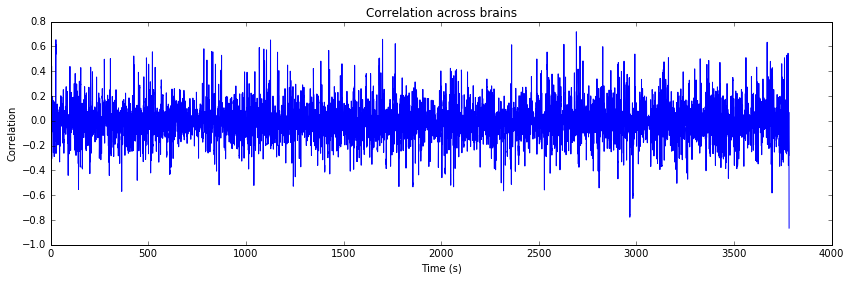

In [147]:
figure(figsize=(14,4))
plot(times, corr)
xlabel('Time (s)')
ylabel('Correlation')
_ = title('Correlation across brains')

Now that we have the brain correlations through time, we want to sync it up with the lecture video, to see at which times in the lecture the correlation was high and low. The lecture is also recorded according to the same absolute time of our EEG devices. We used a screen flashing white and black at specific times to know the exact timings of the lecture video.

In [148]:
"""Syncing to video content"""
start_white = 1492292390.07327
start_black = 1492292391.07712
end_white = 1492297704.94143
end_black = 1492297705.94569

In [149]:
print("Brain recordings lasted for", int(times[-1]), "seconds")

Brain recordings lasted for 3781 seconds


In [150]:
print("Brain recordings started", pierre_t[0] - start_black, "seconds after black screen")

Brain recordings started 166.922879934 seconds after black screen


In [151]:
print("Brain recordings ended", end_black - pierre_t[-1], "seconds before black screen")

Brain recordings ended 1393.94568992 seconds before black screen
